In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.regression.linear_model import OLS

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [29]:
# Relationship
true_intercept = 100
true_slope1 = 5
true_power1 = 2
true_slope2 = -5

# Predictors
n_obs = 100

x1_mean = 5
x1_sd = 2
x1 = rng.normal(x1_mean, x1_sd, n_obs)
x1array = xr.DataArray(x1, dims = ["plot_dim"])

x2_mean = 10
x2_sd = 3
x2 = rng.normal(x2_mean, x2_sd, n_obs)
x2array = xr.DataArray(x2, dims = ["plot_dim"])


# Target
true_line = true_intercept + (true_slope1 *  (x1 ** true_power1)) + (true_slope2 * x2)
noise_mean = 0
noise_sd = 20
noise = rng.normal(noise_mean, noise_sd, n_obs)
y = true_line + noise

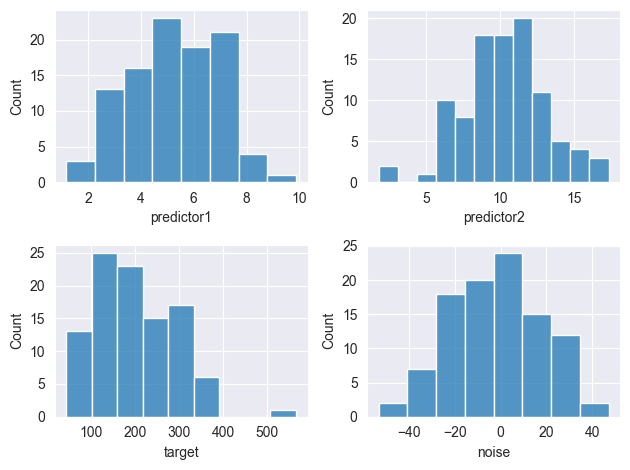

In [30]:
# Distributions of data
fig, ax = plt.subplots(2, 2)

_ = sns.histplot(x1, ax = ax[0, 0])
_ = ax[0, 0].set_xlabel("predictor1")

_ = sns.histplot(x2, ax = ax[0, 1])
_ = ax[0, 1].set_xlabel("predictor2")

_ = sns.histplot(y, ax = ax[1, 0])
_ = ax[1, 0].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[1, 1])
_ = ax[1, 1].set_xlabel("noise")

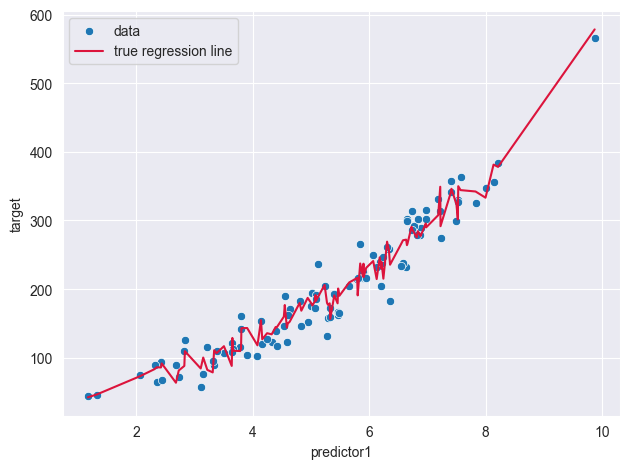

In [31]:
# True regression line
_ = sns.scatterplot(x = x1, y = y, label = "data")
_ = sns.lineplot(x = x1, y = true_line, label = "true regression line", color = "crimson")
_ = plt.xlabel("predictor1")
_ = plt.ylabel("target")

## Frequentist OLS

In [34]:
constant = np.ones(n_obs)
exog = np.stack([x1, x2, constant]).transpose()

In [35]:
ols = OLS(endog = y, exog = exog)

In [36]:
ols_res = ols.fit()
ols_fitted = ols.predict(ols_res.params, exog)

In [37]:
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     506.8
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           4.47e-52
Time:                        17:18:30   Log-Likelihood:                -473.65
No. Observations:                 100   AIC:                             953.3
Df Residuals:                      97   BIC:                             961.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            51.1796      1.650     31.027      0.000      47.906      54.453
x2            -4.3191      0.967     -4.465      0.000      -6.239      -2.399
const        -25.3853     14.032     -1.809      0.074     -53.236       2.465
==============================================================================
Omnibus:                        3.359   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.186   Jarque-Bera (JB):                2.721
Skew:                           0.372   Prob(JB):                        0.256
Kurtosis:                       3.314   Cond. No.                         59.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

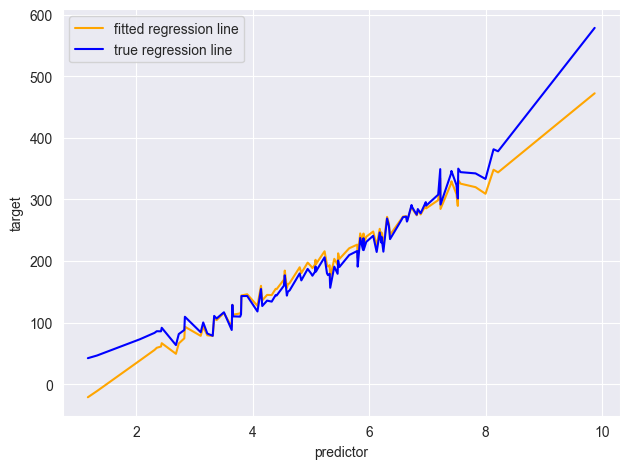

In [38]:
_ = sns.lineplot(
    x = x1, 
    y = ols_fitted, 
    label = "fitted regression line", color = "orange")
_ = sns.lineplot(
    x = x1, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Normal priors


In [ ]:
# Create model
flat_model = pm.Model()

In [ ]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 10)
    slope = pm.Normal("slope", mu = 0, sigma = 10)
    error = pm.Normal("error", mu = 0, sigma = 10)

    # Expected value
    cond_mean = intercept + slope * x 

    # Likelihood
    likelihood = pm.Normal("outcome", mu = cond_mean, sigma = error, observed = y)

In [ ]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

In [ ]:
# Prior predictive check
y_flat_prior = (flat_prior.prior["intercept"] + flat_prior.prior["slope"] * xarray).stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

In [ ]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

In [ ]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

In [ ]:
# Simulate fitted regression lines
flat_posterior.posterior["fitted"] = flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray

In [ ]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

In [ ]:
# Plot regression lines
_ = az.plot_lm(
    idata = flat_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_line, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

In [ ]:
# Plot posterior distribution
_ = az.plot_ppc(flat_posterior, num_pp_samples = 1000)